In [11]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from dataset.carvana_dataset import CarvanaEvalDataset
import cv2
from utils.scripts import rle_encode, rle_decode
from model.link_net import LinkNet18
from pathlib import Path
from torch.utils.data import DataLoader
from tqdm import tqdm

In [2]:
DATA_DIR = Path(r'input')
TRAIN_DIR = DATA_DIR / 'train'
TEST_DIR = DATA_DIR / 'test'
TRAIN_MASKS = DATA_DIR / 'train_masks'
MODEL = Path(r'model/linknet18_epoch9_val_loss0.983.pth')

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
model = LinkNet18(num_classes=1)
model.load_state_dict(torch.load(MODEL))
model.to(device)
model.eval()

LinkNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (encoder1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tr

In [5]:
test_df = pd.read_csv(DATA_DIR / 'sample_submission.csv')
test_df.head(5)

,img,rle_mask
0,0004d4463b50_01.jpg,1 1
1,0004d4463b50_02.jpg,1 1
2,0004d4463b50_03.jpg,1 1
3,0004d4463b50_04.jpg,1 1
4,0004d4463b50_05.jpg,1 1


In [50]:
test_dataset = CarvanaEvalDataset(test_df, TEST_DIR)

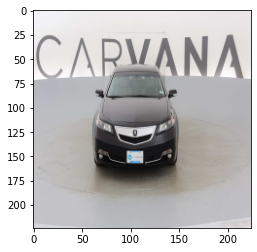

In [51]:
import matplotlib.pyplot as plt
image = test_dataset[0]['image']
plt.imshow(image.permute(1, 2, 0))
plt.show()

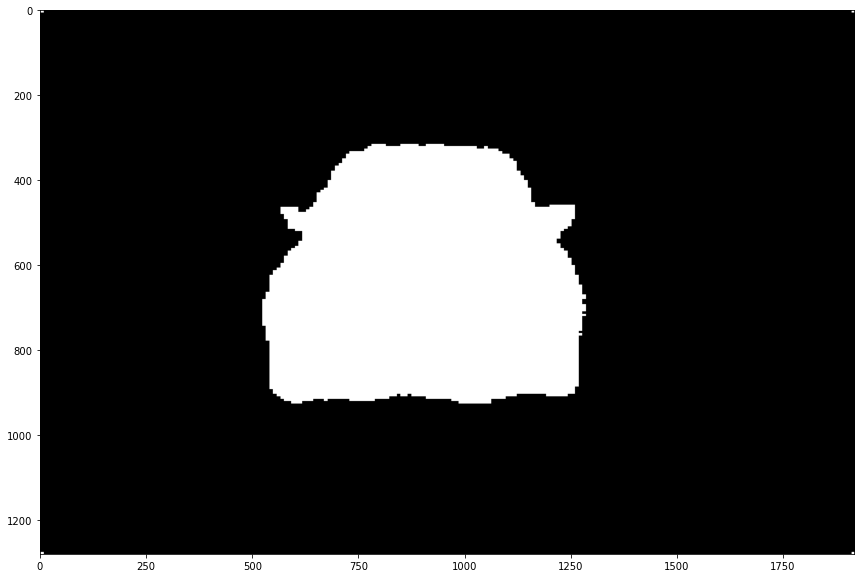

In [48]:
out = model(image.unsqueeze(0).to(device))
out = torch.sigmoid(out)*255
out = nn.functional.interpolate(out, (1280, 1918))
out = out.squeeze(0).squeeze(0)
out = out.data.cpu().numpy()
out = (out > 0.005).astype(np.uint8)
plt.figure(figsize=(15, 10))
plt.imshow(out, cmap='gray')
plt.show()

In [53]:
for i in tqdm(range(len(test_dataset))):
    image = test_dataset[i]['image']
    out = model(image.unsqueeze(0).to(device))
    out = torch.sigmoid(out)*255
    out = nn.functional.interpolate(out, (1280, 1918))
    out = out.squeeze(0).squeeze(0)
    out = out.data.cpu().numpy()
    out = (out > 0.005).astype(np.uint8)
    rle_str = rle_encode(out)
    
    test_df.iloc[i, 1] = rle_str

100%|████████████████████████████████████████████████████████████████████████| 100064/100064 [1:46:59<00:00, 15.59it/s]


In [56]:
test_df.to_csv('my_submission.csv', index=False)